In [1]:
import awkward as ak
import numpy as np
import pickle as pkl
import hist 
import matplotlib.pyplot as plt
import mplhep as hep
import uproot

import os
from numba import njit

hep.style.use('CMS')

In [31]:
import fastjet as fj
import awkward as ak
import pickle as pkl
import numpy as np
import vector
import matplotlib.pyplot as plt
import hist
import mplhep as hep

import os

vector.register_awkward()

in addition to cross sections store whether event contains Z and b and c

add compress option to pythia function

add substructure observables

In [ ]:
class PythiaAnalyzer:
    # analyze events
    # cluster jets
    # find events with b quarks, get event nums? for tagging
    # have work on a batch and then have separate multiproc set up
    # make kinematic plots?

In [ ]:
def cluster_jets(particles, radius=0.4, min_pt=2.5, cluster_algo=fj.antikt_algorithm):
    '''
    particles: 
    radius: 
    min_pt: 
    cluster_algo: 
    '''
    
    jet_def = fj.JetDefinition(cluster_algo, radius)
    cluster = fj.ClusterSequence(particles, jet_def)

    jets = cluster.inclusive_jets(min_pt=min_pt)
    constituents = cluster.constituents(min_pt=min_pt)
    
    return jets, constituents

In [ ]:
pairs = ak.cartesian((jets, constituents), axis=2)
jet_axes, _ = ak.unzip(pairs)

delta_phi = jet_axes.phi - constituents.phi
delta_eta = jet_axes.eta - constituents.eta

delta_R = np.sqrt(delta_phi**2 + delta_eta**2)
girth = ak.sum(constituents.pt * delta_R, axis=2) / jets.pt

In [ ]:
descending_pt = ak.argsort(constituents.pt, axis=2, ascending=False)

masked_con = ak.mask(constituents[descending_pt], ak.num(constituents, axis=2) > 1)
ls =masked_con[:, :, :1].pt - masked_con[:, :, 1:2].pt
jets['lesub'] = ls

In [33]:
x = 'test'
x[:-2]

'te'

In [38]:
NUM_RUNS = 4
RAW_DATA_DIRS = [f'/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/run{i}/' for i in range(NUM_RUNS)]

for i, dir in enumerate(RAW_DATA_DIRS):
    for file in os.listdir(dir):
    
        with open(dir + file, 'rb') as in_file:
            events, sig, err = pkl.load(in_file)
            
            ak.to_parquet(events, f'/Users/ravikoka/repos/z_plus_hf/feasibility/parquet_test/run{i}/'+file[:-3] + 'parquet')

In [44]:
NUM_RUNS = 4
RAW_DATA_DIRS = [f'/Users/ravikoka/repos/z_plus_hf/feasibility/parquet_test/run{i}/' for i in range(NUM_RUNS)]

for i, dir in enumerate(RAW_DATA_DIRS):
    for file in os.listdir(dir):
        events = ak.from_parquet(f'/Users/ravikoka/repos/z_plus_hf/feasibility/parquet_test/run{i}/'+file)
        #with open(dir + file, 'rb') as in_file:
            #events, sig, err = pkl.load(in_file)

In [46]:
NUM_RUNS = 4
RAW_DATA_DIRS = [f'/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/run{i}/' for i in range(NUM_RUNS)]

for i, dir in enumerate(RAW_DATA_DIRS):
    for file in os.listdir(dir):
    
        with open(dir + file, 'rb') as in_file:
            events, _, _ = pkl.load(in_file)

In [45]:
events

<Array [{px: [0, ...], py: [...], ...}, ...] type='500 * {px: var * float64...'>

In [41]:
NUM_RUNS = 4
RAW_DATA_DIRS = [f'/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/run{i}/' for i in range(NUM_RUNS)]

for i, dir in enumerate(RAW_DATA_DIRS):
    for file in os.listdir(dir):
    
        with open(dir + file, 'rb') as in_file:
            events, sig, err = pkl.load(in_file)
        
        with open(f'/Users/ravikoka/repos/z_plus_hf/feasibility/pickle_test/run{i}/'+file, 'wb') as out_file:
            pkl.dump(events, out_file)
            #ak.to_parquet(events, f'/Users/ravikoka/repos/z_plus_hf/feasibility/parquet_test/run{i}/'+file[:-3] + 'parquet')

In [11]:
with open('../RaviTest.pkl', 'rb') as f:
    ak_particle_list = pkl.load(f)

In [13]:
def fastjet_antikt_clustering(particle_list):
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4) # Anti-kT Clustering with R = 0.1
    vector.register_awkward()
    jpt=[];jpx=[];jpy=[];jpz=[];jE=[];jeta=[];jphi=[];cpt=[];ceta=[];cphi=[];cpx=[];cpy=[];cpz=[];cmass=[];ccharge=[];cmother=[]
    # delr=[];
    pdg=[]; Event_counter = []
    num_events = len(particle_list)
    batches = ak.Array([i for i in range(num_events) if i%1000==0])
    batches = ak.concatenate([batches,num_events])
    for i in range(len(batches)):
        if i+1 < len(batches):
            partial_list=ak.Array(particle_list[batches[i]:batches[i+1]],with_name="Momentum4D")
            partial_cluster=fastjet.ClusterSequence(partial_list, jetdef)
            jpt_cut=10
            jet_output=partial_cluster.inclusive_jets(min_pt=jpt_cut)
            jpx.append(ak.Array(jet_output,with_name="Momentum4D").px)
            jpy.append(ak.Array(jet_output,with_name="Momentum4D").py)
            jpz.append(ak.Array(jet_output,with_name="Momentum4D").pz)
            jE.append(ak.Array(jet_output,with_name="Momentum4D").E)
            jpt.append(ak.Array(jet_output,with_name="Momentum4D").pt)
            jeta.append(ak.Array(jet_output,with_name="Momentum4D").eta) #PSEUDORAPIDITY
            jphi.append(ak.Array(jet_output,with_name="Momentum4D").phi)
            
            constituent_output=partial_cluster.constituents(min_pt=jpt_cut)
            cpt_cut=0.2 ##

            cpt.append(([constituent_output[i]["pt"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))]))
            ceta.append([constituent_output[i]["eta"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
            cphi.append([constituent_output[i]["phi"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
            ccharge.append([constituent_output[i]["charge"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
            cmother.append([constituent_output[i]["mp"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
            # Event_counter.append([constituent_output[i]["Event_Count"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
            pdg.append([constituent_output[i]["pdg"][constituent_output[i]["pt"]>cpt_cut] for i in range(len(constituent_output))])
    return ak.concatenate(jpt),ak.concatenate(jeta),ak.concatenate(jphi),ak.concatenate(cpt),ak.concatenate(ceta),ak.concatenate(cphi),ak.concatenate(ccharge),ak.concatenate(cmother),ak.concatenate(pdg)

In [14]:
fastjet_antikt_clustering(ak_particle_list)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


(<Array [[], [11.7], [], [], ..., [], [], [], []] type='9999 * var * float64'>,
 <Array [[], [0.862], [], [], ..., [], [], [], []] type='9999 * var * float64'>,
 <Array [[], [1.24], [], [], ..., [], [], [], []] type='9999 * var * float64'>,
 <Array [[], [[2.08, ..., 0.707]], ..., [], []] type='9999 * var * var * flo...'>,
 <Array [[], [[0.89, ..., 0.736]], ..., [], []] type='9999 * var * var * flo...'>,
 <Array [[], [[1.24, 1.13, ..., 1.16]], ..., []] type='9999 * var * var * fl...'>,
 <Array [[], [[1, 1, -1, ..., 0, 0]], ..., []] type='9999 * var * var * float64'>,
 <Array [[], [[2, 2, 2, ..., 2, 2, 2]], ..., []] type='9999 * var * var * int64'>,
 <Array [[], [[211, 211, ..., 22, 22]], ..., []] type='9999 * var * var * int64'>)

In [ ]:
fj.JetDefinition('')

In [15]:
# https://arxiv.org/pdf/2007.03577 circlular histogram

In [ ]:
#def read_pythia(dir):
    

In [86]:
RAW_DATA_DIR = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run0/'

In [55]:
SAMPLE_FILE = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run0/pp_Z_production_13600_0.pkl'
with open(SAMPLE_FILE, 'rb') as in_file:
    events, sig, err = pkl.load(in_file)

In [17]:
SAMPLE_FILE2 = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run0/pp_Z_production_13600_0.pkl'
with open(SAMPLE_FILE2, 'rb') as in_file:
    events2, _, _ = pkl.load(in_file)

In [28]:
def func():
    SAMPLE_FILE2 = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run0/pp_Z_production_13600_0.pkl'
    with open(SAMPLE_FILE2, 'rb') as in_file:
        events2, _, _ = pkl.load(in_file)
    return events2 

In [19]:
ak.to_parquet(events2, "arr_event_test2.parquet")

  created_by: parquet-cpp-arrow version 19.0.1
  num_columns: 9
  num_rows: 500
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [25]:
%timeit events = ak.from_parquet("/Users/ravikoka/repos/z_plus_hf/feasibility/arr_event_test2.parquet")

36.4 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit func()

11.7 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
ak.to_parquet(events, "arr_event_test.parquet")

  created_by: parquet-cpp-arrow version 19.0.1
  num_columns: 9
  num_rows: 500
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [16]:
eee = ak.from_parquet("/Users/ravikoka/repos/z_plus_hf/feasibility/arr_event_test.parquet")

In [18]:
inclusive_particles[0]

<MomentumArray4D [{px: -0.728, py: 2.43, ...}, ...] type='222 * Momentum4D[...'>

In [32]:
inclusive_particles['is_final'] and np.abs(inclusive_particles.eta) < 0.8

ValueError: the truth value of an array whose length is not 1 is ambiguous; use ak.any() or ak.all()

In [56]:
inclusive_particles = ak.zip(
                {
                    'px': events['px'],
                    'py': events['py'],
                    'pz': events['pz'],
                    'E': events['E'],
                    'pdg': events['pdg'],
                    'is_final': events['is_final'],
                    'mother_list': events['mother_list'],
                }, 
                depth_limit=2,
                with_name = 'Momentum4D',
            )
#inclusive_particles = events_zipped[events_zipped['is_final']]

pt_cut = 2.5
eta_cut = 0.8
cut = inclusive_particles.is_final & (inclusive_particles.pt >= pt_cut) & (np.abs(inclusive_particles.eta) <= eta_cut)
particles = inclusive_particles[cut]

In [2]:
array1 = ak.Array([[1, 2, 3], [], [4, 5], [], [], [6, 7, 8, 9]])
ak.to_parquet(array1, "array1.parquet")

  created_by: parquet-cpp-arrow version 19.0.1
  num_columns: 1
  num_rows: 6
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [6]:
ak.to_parquet(particles, "array_test.parquet")

  created_by: parquet-cpp-arrow version 19.0.1
  num_columns: 7
  num_rows: 500
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [7]:
with open(f'array_test.pkl', 'wb') as out_file:
    pkl.dump(particles, out_file)

In [75]:
len(ak.flatten(inclusive_particles))

404110

In [97]:
len(ak.flatten(particles))

916

In [125]:
ak.flatten(particles)

<MomentumArray4D [{px: 0.357, py: -3.54, ...}, ...] type='916 * Momentum4D[...'>

In [98]:
len(ak.flatten(constituents))

286

In [61]:
ak.sum(~particles.is_final)

np.int64(0)

/Users/ravikoka/repos/z_plus_hf/.venv/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1188b3c80>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

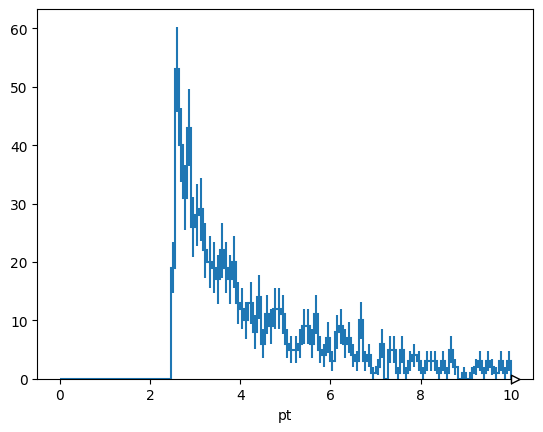

In [55]:
pt = hist.Hist(hist.axis.Regular(110, 0, 10, name='pt'))
pt.fill(ak.flatten(particles.pt))

hep.histplot(pt)

/Users/ravikoka/repos/z_plus_hf/.venv/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x11890db20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

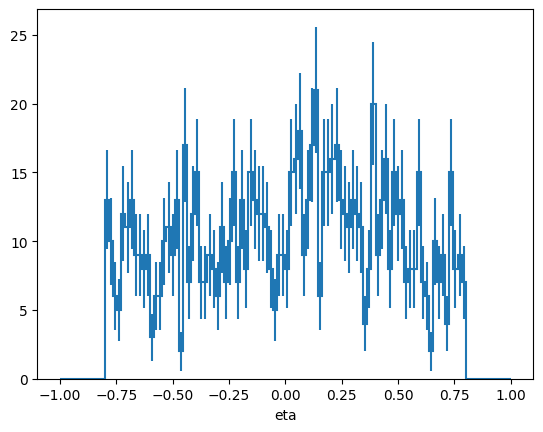

In [56]:
eta = hist.Hist(hist.axis.Regular(110, -1, 1, name='eta'))
eta.fill(ak.flatten(particles.eta))

hep.histplot(eta)

In [96]:
particles

<MomentumArray4D [[], ..., [{px: 0.82, py: 3.98, ...}]] type='500 * var * M...'>

In [146]:
R = 0.4
min_pt = 0
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)
cluster = fj.ClusterSequence(particles, jet_def)

jets = cluster.inclusive_jets(min_pt=min_pt)
constituents = cluster.constituents(min_pt=min_pt)

In [147]:
jets[1]

<MomentumArray4D [{px: -5.33, py: 19.6, ...}, {...}] type='2 * Momentum4D[p...'>

In [148]:
constituents[1]

<MomentumArray4D [[{px: -1.83, py: 5.98, ...}, ...], ...] type='2 * var * M...'>

In [149]:
cluster.constituent_index(min_pt=min_pt)

<Array [[], [[2, 3, 8], [...]], ..., [[0]]] type='500 * var * var * int32'>

In [150]:
constituents

<MomentumArray4D [[], ..., [[{px: 0.82, py: 3.98, ...}]]] type='500 * var *...'>

(<Array [[], [-5.72], [-26.5], ..., [10.4], [0.82]] type='500 * var * float64'>,
 <Array [[], [-6.97], [-5.95], ..., [-13.7], [3.98]] type='500 * var * float64'>,
 <Array [[], [-35.2], [-6.6], ..., [2.92], [2.1]] type='500 * var * float64'>,
 <Array [[], [58.9], [40], ..., [25.4], [4.57]] type='500 * var * float64'>)

In [151]:
num_constituents = ak.num(constituents, axis=2)
num_constituents

<Array [[], [3, 6], [1, 3, 3], ..., [2, 4], [1]] type='500 * var * int64'>

In [152]:
jets

<MomentumArray4D [[], ..., [{px: 0.82, py: 3.98, ...}]] type='500 * var * M...'>

In [392]:
def get_delta_R(left_particles, right_particles):
    
    return np.sqrt((left_particles.eta - right_particles.eta)**2 + (left_particles.phi - right_particles.phi)**2)

In [393]:
get_delta_R(jet_axes, constituents)

<Array [[], [[0.0317, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

In [233]:
pairs = ak.cartesian((jets, constituents), axis=2)
jet_axes, _ = ak.unzip(pairs)

delta_phi = jet_axes.phi - constituents.phi
delta_eta = jet_axes.eta - constituents.eta

delta_R = np.sqrt(delta_phi**2 + delta_eta**2)
delta_R

<Array [[], [[0.0317, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

In [237]:
girth = constituents.pt * delta_R

In [241]:
jets.pt

<Array [[], [20.3, 26.6], ..., [6.46, ...], [4.06]] type='500 * var * float64'>

In [303]:
girth = ak.sum(constituents.pt * delta_R, axis=2) / jets.pt
girth

<Array [[], [0.0433, 0.0866], ..., [0.11, ...], [0]] type='500 * var * float64'>

In [245]:
jets.pt

<Array [[], [20.3, 26.6], ..., [6.46, ...], [4.06]] type='500 * var * float64'>

https://indico.cern.ch/event/1071399/contributions/4505115/attachments/2305850/3922853/fastjet%20%285%29.pdf

In [264]:
descending_pt = ak.argsort(jets.pt, axis=1, ascending=False)

In [259]:
ak.sum(constituents[chonkiest_jet][1].pt, axis=1)

<Array [26.6, 20.3] type='2 * float64'>

In [276]:
ak.num(jets) 

<Array [0, 2, 3, 1, 2, 3, 1, 0, ..., 5, 0, 1, 1, 0, 2, 2, 1] type='500 * int64'>

In [313]:
#jets_descending_pt = jets[descending_pt]
leading = jets[descending_pt][:, :1]
subleading = jets[descending_pt][:, 1:2]

lesub = leading.pt[ak.num(jets) > 1] - subleading.pt[ak.num(jets) > 1]

In [322]:
descending_pt = ak.argsort(constituents.pt, axis=2, ascending=False)

In [323]:
constituents.pt

<Array [[], [[6.25, ...], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [326]:
constituents.pt[descending_pt][:, :, :1]

<Array [[], [[7.35], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [327]:
constituents.pt[descending_pt][:, :, 1:2]

<Array [[], [[6.73], [4.87]], ..., [...], [[]]] type='500 * var * var * flo...'>

In [353]:
#jets_descending_pt = jets[descending_pt]
descending_pt = ak.argsort(constituents.pt, axis=2, ascending=False)
leading = constituents[descending_pt][:, :, :1]
subleading = constituents[descending_pt][:, :, 1:2]

#lesub = leading.pt[ak.num(jets) > 1] - subleading.pt[ak.num(jets) > 1]
#lesub = ak.pad_none(leading.pt, 1, axis=1) - ak.pad_none(subleading.pt, 1, axis=1) 

In [373]:
ak.num(constituents, axis=2) > 1

<Array [[], [True, True], ..., [True, ...], [False]] type='500 * var * bool'>

In [375]:
ak.where((ak.num(constituents, axis=2)>1))

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [390]:
constituents.pt

<Array [[], [[6.25, ...], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [378]:
descending_pt = ak.argsort(constituents.pt, axis=2, ascending=False)

masked_con = ak.mask(constituents[descending_pt], ak.num(constituents, axis=2) > 1)

In [379]:
masked_con.pt

<Array [[], [[7.35, ...], ...], ..., [None]] type='500 * var * option[var *...'>

In [383]:
ls =masked_con[:, :, :1].pt - masked_con[:, :, 1:2].pt

In [384]:
jets['lesub'] = ls

In [391]:
jets[2][0]

<MomentumRecord4D {px: 2.62, py: 1.06, pz: -1.15, ...} type='Momentum4D[px:...'>

In [372]:
descending_pt

<Array [[], [[1, 2, 0], ...], ..., [None]] type='500 * var * option[var * i...'>

In [371]:
masked_con[descending_pt]

IndexError: cannot slice ListArray (of length 81) with [[1, 2, 0], [5, 2, 1, 3, 4, 0], [1, 0, 2], ..., [0, ...], [1, 3, 0, 2], [0, 1]]: index out of range while attempting to get index 3 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [369]:
descending_pt = ak.argsort(masked_con.pt, axis=2, ascending=False)
leading = masked_con[descending_pt][:, :, :1]
leading.pt

IndexError: cannot slice ListArray (of length 81) with [[1, 2, 0], [5, 2, 1, 3, 4, 0], [1, 0, 2], ..., [0, ...], [1, 3, 0, 2], [0, 1]]: index out of range while attempting to get index 3 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [366]:
leading = constituents[descending_pt][:, :, :1][ak.num(constituents, axis=2) > 1]
subleading = constituents[descending_pt][:, :, 1:2][ak.num(constituents, axis=2) > 1]

IndexError: cannot slice ListArray (of length 500) with [[], [[1, 2, 0], [5, 2, 1, 3, 4, 0]], [...], ..., [[1, 0], [1, 3, 2, 0]], []]: jagged slice inner length differs from array inner length (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_descend.cpp#L27)

In [344]:
leading

<MomentumArray4D [[[{px: -1.52, ...}], ...], ..., [...]] type='123 * var * ...'>

In [338]:
ak.sum(~(ak.num(ak.pad_none(subleading.pt, 1, axis=1)) == ak.num(ak.pad_none(leading.pt, 1, axis=1))))

np.int64(0)

In [330]:
leading.pt

<Array [[], [[7.35], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [340]:
one = ak.pad_none(leading.pt, 1, axis=1)
two = ak.pad_none(subleading.pt, 1, axis=1)

In [ ]:
leading = constituents[descending_pt][:, :, :1]
leading = ak.mask(leading, )

In [342]:
np.subtract(one, two, where=True)

ValueError: cannot broadcast nested list (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListArray_broadcast_tooffsets.cpp#L27)

In [339]:
ak.pad_none(leading.pt, 1, axis=1) - ak.pad_none(subleading.pt, 1, axis=1)

ValueError: cannot broadcast nested list (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-45/awkward-cpp/src/cpu-kernels/awkward_ListArray_broadcast_tooffsets.cpp#L27)

In [316]:
leading.pt

<Array [[], [[3.56, ..., 5.52]], ..., [[4.06]]] type='500 * var * var * flo...'>

In [289]:
lesub

<Array [[6.26], [3.62], ..., [1.88], [12.2]] type='123 * var * float64'>

In [285]:
leading.pt

<Array [[], [26.6], [19.1], ..., [18.6], [4.06]] type='500 * var * float64'>

In [293]:
test_ls = ak.pad_none(leading.pt, 1, axis=1) - ak.pad_none(subleading.pt, 1, axis=1) 

test_ls

<Array [[None], [6.26], ..., [12.2], [None]] type='500 * var * ?float64'>

In [304]:
girth

<Array [[], [0.0433, 0.0866], ..., [0.11, ...], [0]] type='500 * var * float64'>

In [305]:
jets['girth'] = girth

In [311]:
jets['lesub'] = test_ls

ValueError: cannot broadcast nested list

In [310]:
jets[1][0]

<MomentumRecord4D {px: -5.33, py: 19.6, pz: -17.5, ...} type='Momentum4D[px...'>

/Users/ravikoka/repos/z_plus_hf/.venv/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x13bb4cb60>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

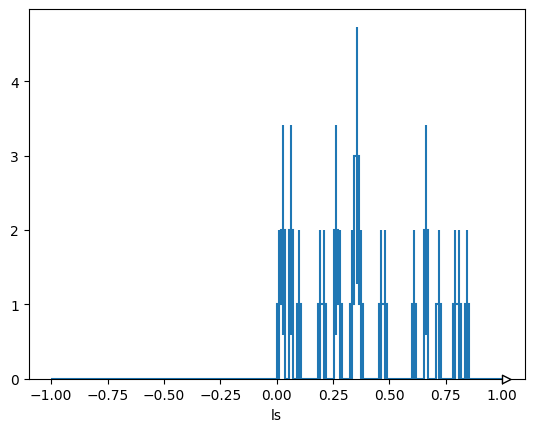

In [297]:
lesubhist = hist.Hist(hist.axis.Regular(110, -1, 1, name='ls'))
lesubhist.fill(ak.drop_none(ak.ravel(test_ls)))

hep.histplot(lesubhist)

/Users/ravikoka/repos/z_plus_hf/.venv/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x13bb4d670>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

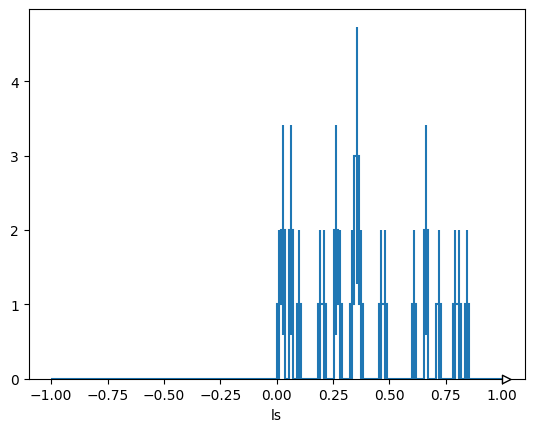

In [282]:
lesubhist = hist.Hist(hist.axis.Regular(110, -1, 1, name='ls'))
lesubhist.fill(ak.ravel(lesub))

hep.histplot(lesubhist)

In [280]:
subleading.pt

<Array [[], [20.3], [15.4], ..., [35.1], [6.46], []] type='500 * var * float64'>

In [272]:
subleading.pt

<Array [[], [20.3], [15.4], ..., [35.1], [6.46], []] type='500 * var * float64'>

In [254]:
thicc_jets = jets[chonkiest_jet]
thicc_jets.pt

<Array [[], [26.6, 20.3], ..., [18.6, ...], [4.06]] type='500 * var * float64'>

In [262]:
leading = thicc_jets.pt[:, :1]

<Array [[], [26.6], [19.1], ..., [18.6], [4.06]] type='500 * var * float64'>

In [263]:
subleading = thicc_jets.pt[:, 1:2]

<Array [[], [20.3], [15.4], ..., [35.1], [6.46], []] type='500 * var * float64'>

In [247]:
ak.sort(jets.pt, axis=1)

<Array [[], [20.3, 26.6], ..., [6.46, ...], [4.06]] type='500 * var * float64'>

In [239]:
constituents.pt

<Array [[], [[6.25, ...], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [238]:
girth

<Array [[], [[0.198, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

/Users/ravikoka/repos/z_plus_hf/.venv/lib/python3.12/site-packages/mplhep/utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x13b90bec0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

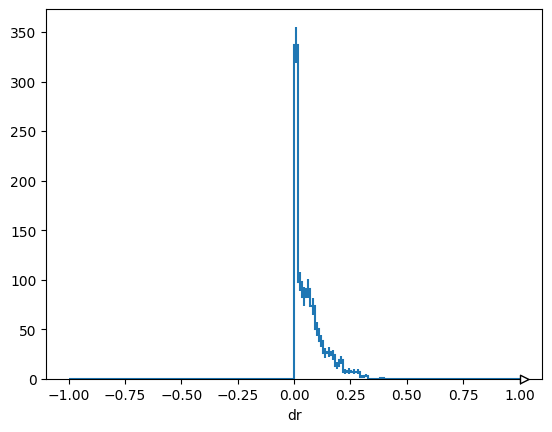

In [235]:
dR = hist.Hist(hist.axis.Regular(110, -1, 1, name='dr'))
dR.fill(ak.ravel(delta_R))

hep.histplot(dR)

In [236]:
ak.max(delta_R)

np.float64(6.237033907652206)

In [197]:
pairs = ak.cartesian((jets, constituents), axis=2)
pairs[1][1]

<Array [({...}, {...}), ..., ({...}, ..., ...)] type='6 * (Momentum4D[px: f...'>

In [201]:
jets_axis, cons = ak.unzip(pairs)

In [217]:
dphi = jets_axis.phi - cons.phi
dphi

<Array [[], [[-0.0309, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

In [219]:
dphi[1]

<Array [[-0.0309, 0.0572, -0.0337], [...]] type='2 * var * float64'>

In [229]:
jets[1][0].phi - constituents[1][0].phi

<Array [-0.0309, 0.0572, -0.0337] type='3 * float64'>

In [224]:
jets_axis[1].phi

<Array [[1.84, 1.84, 1.84], [-1.59, ..., -1.59]] type='2 * var * float64'>

In [225]:
constituents.phi

<Array [[], [[1.87, ...], ...], ..., [[1.37]]] type='500 * var * var * float64'>

In [226]:
cons.phi

<Array [[], [[1.87, ...], ...], ..., [[1.37]]] type='500 * var * var * float64'>

In [215]:
1.84 - constituents[1][0].phi

<Array [-0.0273, 0.0607, -0.0301] type='3 * float64'>

In [207]:
jets_axis[1][1]

<MomentumArray4D [{px: -0.386, py: -26.6, ...}, ...] type='6 * Momentum4D[p...'>

In [193]:
cons[1]

<MomentumArray4D [[{px: -1.83, py: 5.98, ...}, ...], ...] type='4 * var * M...'>

In [177]:
delta_R = get_delta_R(jets, constituents)

<Array [[], [[0.0317, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

In [178]:
delta_R

<Array [[], [[0.0317, ...], ...], ..., [[0]]] type='500 * var * var * float64'>

In [165]:
constituents[1]

<MomentumArray4D [[{px: -1.83, py: 5.98, ...}, ...], ...] type='2 * var * M...'>

In [166]:
constituents.pt

<Array [[], [[6.25, ...], ...], ..., [[4.06]]] type='500 * var * var * float64'>

In [172]:
ak.sum(constituents.pt[1][0])

np.float64(20.326070813906313)

In [168]:
ak.sum(constituents.pt, axis=2)

<Array [[], [20.3, 26.6], ..., [6.46, ...], [4.06]] type='500 * var * float64'>

In [160]:
jets.pt

<Array [[], [20.3, 26.6], ..., [6.46, ...], [4.06]] type='500 * var * float64'>

In [153]:
ak.max(ak.num(jets, axis=1))

np.int64(6)

In [129]:
test = ak.concatenate([jets, 'n': num_constituents], axis=-1)

SyntaxError: invalid syntax (4008731359.py, line 1)

In [159]:
jets['num_con'] = num_constituents

In [158]:
constituents[1][1]

<MomentumArray4D [{px: 0.357, py: -3.54, ...}, ...] type='6 * Momentum4D[px...'>

In [155]:
jets[1]

<MomentumArray4D [{px: -5.33, py: 19.6, ...}, {...}] type='2 * Momentum4D[p...'>

In [128]:
test

<Array [[], [...], ..., [{px: 0.82, ...}, 1]] type='500 * var * union[Momen...'>

In [ ]:
ak.zip

In [107]:
test = ak.concatenate([constituents, num_constituents])

In [108]:
test

<Array [[], [[{px: ..., ...}, ...]], ..., [1]] type='1000 * union[var * var...'>

In [106]:
test[1]

<Array [([{...}, ...], 9)] type='1 * (var * Momentum4D[px: float64, py: flo...'>

In [89]:
jets

<MomentumArray4D [[], ..., [{px: 0.82, py: 3.98, ...}]] type='500 * var * M...'>

In [83]:
ak.sum(constituents[2].px)

np.float64(-26.468476551300274)

In [87]:
ak.sum(constituents[2].pt)

np.float64(37.36345286594101)

In [86]:
constituents.pt

<Array [[], [[3.56, ..., 6.73]], ..., [[4.06]]] type='500 * var * var * flo...'>

In [88]:
ak.max(constituents.pt, axis=2)

<Array [[], [7.35], [9.78], ..., [5.98], [4.06]] type='500 * var * ?float64'>

In [85]:
ak.sum(constituents.pt, axis=2)

<Array [[], [46.9], [37.4], ..., [25.1], [4.06]] type='500 * var * float64'>

In [75]:
num_constituents = ak.num(constituents, axis=2)

<Array [[], [9], [7], [1], ..., [], [2], [6], [1]] type='500 * var * int64'>

In [52]:
ak.sum(particles.E)

np.float64(7667.565663609246)

In [53]:
ak.sum(constituents.E)

np.float64(7667.565663609246)

In [54]:
ak.flatten(particles)

<MomentumArray4D [{px: 0.357, py: -3.54, ...}, ...] type='916 * Momentum4D[...'>

In [ ]:
particles

In [135]:
ak.flatten(ak.flatten(constituents))

<MomentumArray4D [{px: 0.357, py: -3.54, ...}, ...] type='916 * Momentum4D[...'>

In [68]:
ak.sum(ak.flatten(ak.flatten(constituents.px)) - ak.flatten(particles.px))

np.float64(0.0)

In [61]:
ak.ravel(constituents)

<Array [0.357, -0.139, -1.83, -1.52, ..., 548, 671, 229] type='9221 * float64'>

In [121]:
ak.flatten(constituents, axis=None)

<Array [0.357, -0.139, -1.83, -1.52, ..., 548, 671, 229] type='9221 * float64'>

In [106]:
jets[2]

<MomentumArray4D [{px: -26.5, py: -5.95, pz: -6.6, ...}] type='1 * Momentum...'>

In [109]:
ak.flatten(constituents[2])

<MomentumArray4D [{px: 2.62, py: 1.06, ...}, ..., {...}] type='7 * Momentum...'>

In [110]:
particles[2]

<MomentumArray4D [{px: 2.62, py: 1.06, ...}, ..., {...}] type='7 * Momentum...'>

In [101]:
constituents[2]

<MomentumArray4D [[{px: 2.62, py: 1.06, ...}, ...]] type='1 * var * Momentu...'>

In [66]:
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)
jets = fj.ClusterSequence(particles, jet_def)

In [89]:
events

<Array [{px: [0, ...], py: [...], ...}, ...] type='500 * {px: var * float64...'>

In [90]:
jets = fj.ClusterSequence(particles, jet_def)

In [52]:
particles

<Array [[{px: -0.728, py: ..., ...}, ...], ...] type='500 * var * Momentum4...'>

In [103]:
jets.inclusive_jets(min_pt=10)

<Array [] type='0 * Momentum4D[px: float64, py: float64, pz: float64, E: fl...'>

In [104]:
jets.constituents(min_pt=10)

<Array [] type='0 * var * Momentum4D[px: float64, py: float64, pz: float64,...'>

In [92]:
ak.sum(jets.constituents(min_pt=10)[0][0]['E'])

np.float64(68.63297148911091)

In [41]:
for i in range(len(jets.constituents())):
    if len(jets.constituents()[0][i]) > 1:
        print('hi', i, len(jets.constituents()[0][i]))

hi 25 2
hi 34 2
hi 36 2
hi 43 2
hi 44 4
hi 46 2
hi 52 2
hi 58 2
hi 59 2
hi 63 2
hi 64 4
hi 69 2
hi 72 2
hi 74 2
hi 75 2
hi 78 2
hi 82 4
hi 84 2
hi 86 2
hi 87 2
hi 90 2
hi 91 3
hi 93 3
hi 94 3
hi 95 2
hi 96 2
hi 97 2
hi 98 2
hi 99 2
hi 100 5
hi 102 2
hi 103 2
hi 104 2
hi 107 6
hi 108 3
hi 110 9
hi 111 7
hi 112 2
hi 113 3
hi 114 3
hi 115 6
hi 116 6
hi 117 10
hi 118 5
hi 119 9


IndexError: cannot slice ListOffsetArray (of length 120) with 120

In [47]:
events_zipped = ak.zip(
                {
                    'px': events['px'],
                    'py': events['py'],
                    'pz': events['pz'],
                    'E': events['E'],
                    'pdg': events['pdg'],
                    'is_final': events['is_final'],
                    'mother_list': events['mother_list'],
                }, 
                depth_limit=2,
                with_name = 'Momentum4D',
            )

In [48]:
particles = events_zipped[events_zipped['is_final']]

In [ ]:
# https://stackoverflow.com/questions/72834275/using-awkward-array-with-zip-unzip-with-two-different-physics-objects

In [3]:
def mass(pairs, left_mass, right_mass):
    left, right = ak.unzip(pairs)
    left_energy = np.sqrt(left.px**2 + left.py**2 + left.pz**2 + left_mass**2)
    right_energy = np.sqrt(right.px**2 + right.py**2 + right.pz**2 + right_mass**2)
    return np.sqrt((left_energy + right_energy)**2 -
                   (left.px + right.px)**2 -
                   (left.py + right.py)**2 -
                   (left.pz + right.pz)**2)

def opposite(pairs):
    left, right = ak.unzip(pairs)
    return pairs[left.pdg == -right.pdg]

def get_dimuon_invariant_mass(events_zipped):
    muon_filter = (events_zipped['pdg'] == 13) & (events_zipped['is_final'])
    muons = events_zipped[muon_filter]

    anti_muon_filter = (events_zipped['pdg'] == -13) & (events_zipped['is_final'])
    anti_muons = events_zipped[anti_muon_filter]
    
    pairs = ak.cartesian([muons, anti_muons])
    
    # inv_mass = hist.Hist(hist.axis.Regular(40, 0, 100, name='temp dimuon invariant mass'))
    # inv_mass.fill(ak.flatten(mass(pairs, 0.1056583755, 0.1056583755)))
    
    return ak.flatten(mass(pairs, 0.1056583755, 0.1056583755))

In [16]:
NUM_RUNS = 4
RAW_DATA_DIRS = [f'/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run{i}/' for i in range(NUM_RUNS)]
inv_mass_dist = hist.Hist(hist.axis.Regular(1000, 0, 100, name='dimuon invariant mass'))

for dir in RAW_DATA_DIRS:
    for file in os.listdir(dir):
    
        with open(dir + file, 'rb') as in_file:
            events, sig, err = pkl.load(in_file)
            
            events_zipped = ak.zip(
                {
                    'px': events['px'],
                    'py': events['py'],
                    'pz': events['pz'],
                    
                    'pdg': events['pdg'],
                    'is_final': events['is_final'],
                    'mother_list': events['mother_list'],
                }, 
                depth_limit=2
            )
        
            inv_mass_dist.fill(get_dimuon_invariant_mass(events_zipped))

NameError: name 'hist' is not defined

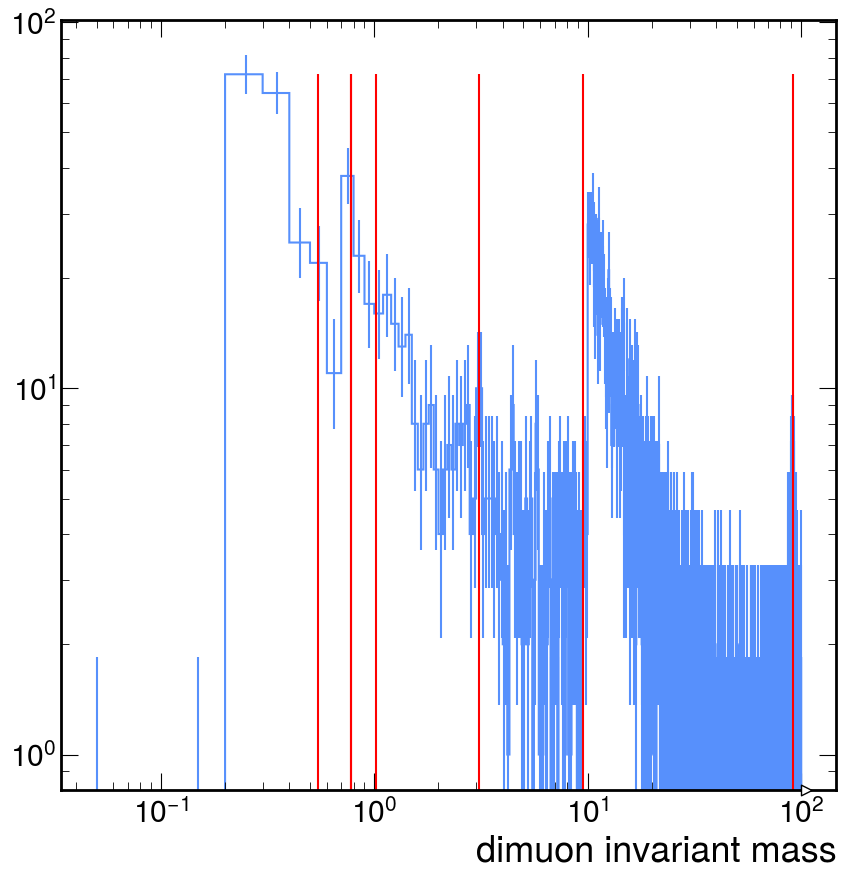

In [8]:
Z_MASS = 91.1876
J_PSI_MASS = 3.096916
UPSILON_MASS = 9.46030
PHI_MASS = 1.019461
NEUTRAL_RHO_MASS = 0.77526
CHARGED_RHO_MASS = 0.77511
ETA_MASS = 0.547862


fig, ax = plt.subplots(1)
hep.histplot(inv_mass_dist, ax=ax)
ax.vlines([Z_MASS, J_PSI_MASS, UPSILON_MASS, NEUTRAL_RHO_MASS, CHARGED_RHO_MASS, PHI_MASS,  ETA_MASS], ymin=0, ymax=np.max(inv_mass_dist), colors='r')
ax.set_yscale('log')
ax.set_xscale('log')

In [156]:
RAW_DATA_DIR = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/run0/'

inv_mass_dist = hist.Hist(hist.axis.Regular(40, 0, 100, name='dimuon invariant mass'))
for file in os.listdir(RAW_DATA_DIR):
    
    with open(RAW_DATA_DIR + file, 'rb') as in_file:
        events, sig, err = pkl.load(in_file)
        
        events_zipped = ak.zip(
            {
                'px': events['px'],
                'py': events['py'],
                'pz': events['pz'],
                'pdg': events['pdg'],
                'is_final': events['is_final'],
                'mother_list': events['mother_list'],
            }, 
            depth_limit=2
        )
        
        inv_mass_dist.fill(get_dimuon_invariant_mass(events_zipped))
        #inv_mass += 

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x137b9f680>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

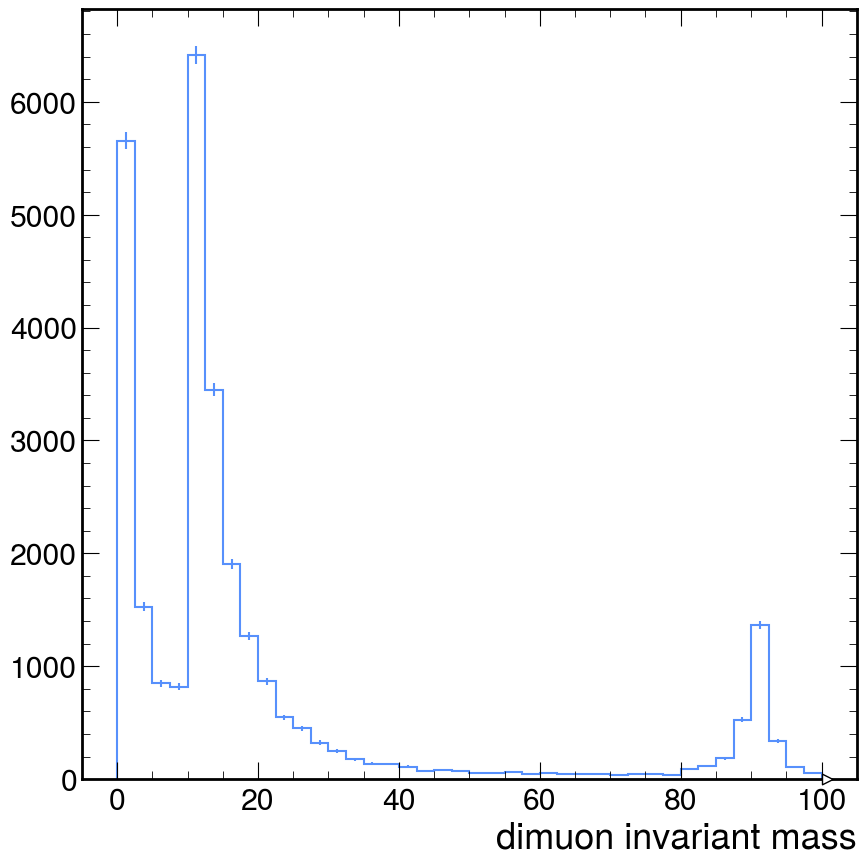

In [5]:
hep.histplot(inv_mass_dist)

In [72]:
events_zipped = ak.zip(
    {
        'px': events['px'],
        'py': events['py'],
        'pz': events['pz'],
        'pdg': events['pdg'],
        'is_final': events['is_final'],
        'mother_list': events['mother_list'],
    }, 
    depth_limit=2
)
events_zipped

<Array [[{px: 0, py: 0, ...}, ..., {...}], ...] type='500 * var * {px: floa...'>

In [127]:
muon_filter = (events_zipped['pdg'] == 13) & (events_zipped['is_final'])
muons = events_zipped[muon_filter]

anti_muon_filter = (events_zipped['pdg'] == -13) & (events_zipped['is_final'])
anti_muons = events_zipped[anti_muon_filter]
#events_zipped[0]

In [129]:
pairs = ak.cartesian([muons, anti_muons])

In [131]:
ak.flatten(pairs)

<Array [({...}, {...}), ..., ({...}, ..., ...)] type='32 * ({px: float64, p...'>

In [132]:
ak.flatten(mass(pairs, 0.1056583755, 0.1056583755))

<Array [11.9, 0.277, 20.4, 39.7, ..., 2.14, 0.283, 20] type='32 * float64'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1770847d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

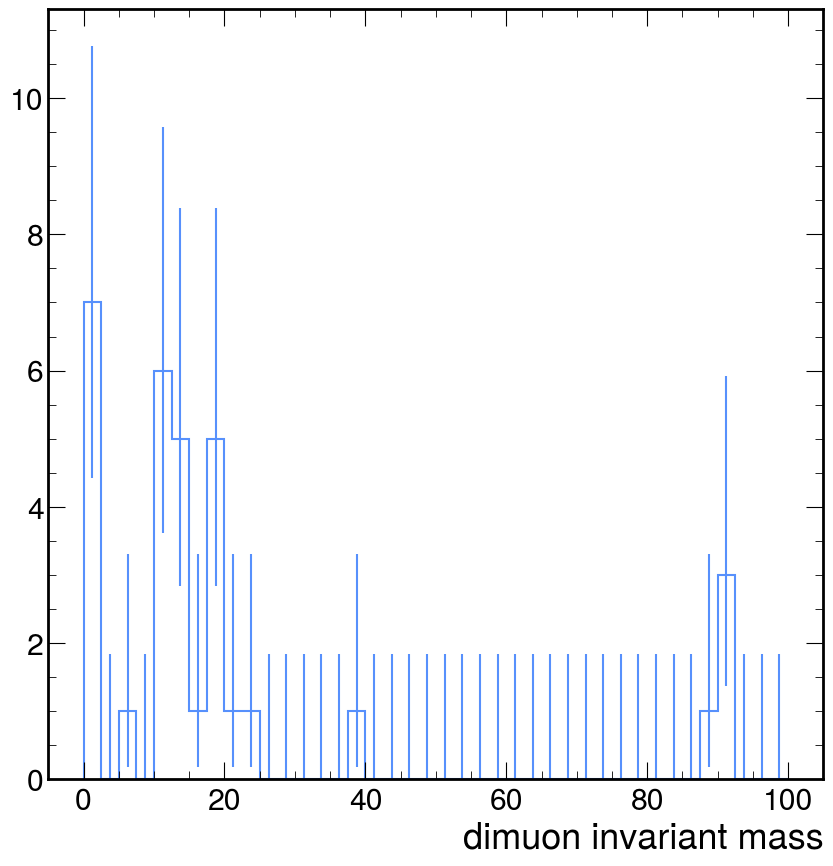

In [142]:
inv_mass = hist.Hist(hist.axis.Regular(40, 0, 100, name='dimuon invariant mass'))
inv_mass.fill(ak.flatten(mass(pairs, 0.1056583755, 0.1056583755)))
hep.histplot(inv_mass)

In [79]:
events_zipped['is_final']
set(ak.flatten(events_zipped[events_zipped['is_final']]['pdg']))

{np.int64(-2212),
 np.int64(-2112),
 np.int64(-321),
 np.int64(-211),
 np.int64(-16),
 np.int64(-14),
 np.int64(-13),
 np.int64(-12),
 np.int64(-11),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(16),
 np.int64(22),
 np.int64(130),
 np.int64(211),
 np.int64(321),
 np.int64(2112),
 np.int64(2212)}

In [143]:
RAW_DATA_DIR = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi_test/run0/'

Z_counter = 0
W_counter = 0

events_w_Z = ak.Array([])
for file in os.listdir(RAW_DATA_DIR):
    
    with open(RAW_DATA_DIR+ file, 'rb') as in_file:
        events, sig, err = pkl.load(in_file)
        
        z_counts = np.sum(events['pdg'] == 23)
        W_counts = np.sum(events['pdg'] == abs(24))
        
        if z_counts > 0:
            contains_Z = ak.any(events['pdg']==23, axis=1)
            events_w_Z = ak.concatenate([events_w_Z, events[contains_Z]])
        
        Z_counter += z_counts
        
        W_counter += W_counts

In [146]:
np.sum(ak.any((events['pdg']==23) & (events['pdg']==13), axis=1))

np.int64(0)

In [28]:
W_counter

np.int64(905)

In [29]:
W_counter

np.int64(905)

In [68]:
Z_counter

np.int64(974)

In [53]:
contains_muon = ak.any(abs(events['pdg'])==13, axis=1)
events_w_muons = events[contains_muon]

In [55]:
events_w_muons[]

<Array [[2212, 2212, 1, -2, ..., 22, 22, 22, 22], ...] type='126 * var * int64'>

In [41]:
ak.any(events_w_Z['pdg']==23, axis=1)

<Array [True, True, True, True, ..., True, True, True, True] type='194 * bool'>

In [42]:
events_zipped = ak.zip(
    {
        'px': events_w_Z['px'],
        'py': events_w_Z['py'],
        'pz': events_w_Z['pz'],
        'pdg': events_w_Z['pdg'],
        'mother_list': events_w_Z['mother_list'],
    }, 
    depth_limit=2
)

In [43]:
events_zipped

<Array [[{px: 0, py: 0, ...}, ..., {...}], ...] type='194 * var * {px: floa...'>

In [44]:
contains_b = ak.any(events_zipped['pdg']==5, axis=1)
contains_b

<Array [False, False, False, False, ..., False, False, False] type='194 * bool'>

In [45]:
events_w_Z_and_b = events_zipped[contains_b]
events_w_Z_and_b

<Array [[{px: 0, py: 0, ...}, ..., {...}], ...] type='27 * var * {px: float...'>

In [46]:
#events_w_Z_and_b['pdg'] == 5

for i, pdg in enumerate(ak.flatten(events_w_Z_and_b['pdg'])):
    if pdg == 5:
        print(f'particle num {i}, b quark')

particle num 3, b quark
particle num 13, b quark
particle num 21, b quark
particle num 28, b quark
particle num 32, b quark
particle num 43, b quark
particle num 54, b quark
particle num 85, b quark
particle num 978, b quark
particle num 980, b quark
particle num 1000, b quark
particle num 2138, b quark
particle num 2140, b quark
particle num 2154, b quark
particle num 2187, b quark
particle num 2455, b quark
particle num 2459, b quark
particle num 2462, b quark
particle num 2465, b quark
particle num 2493, b quark
particle num 3196, b quark
particle num 3200, b quark
particle num 3201, b quark
particle num 3255, b quark
particle num 3887, b quark
particle num 3908, b quark
particle num 3925, b quark
particle num 3940, b quark
particle num 4020, b quark
particle num 4127, b quark
particle num 4224, b quark
particle num 4706, b quark
particle num 4710, b quark
particle num 4716, b quark
particle num 4717, b quark
particle num 4739, b quark
particle num 4997, b quark
particle num 5002, b

In [37]:
np.sum(events_zipped['pdg'] == 5)

np.int64(146)

In [47]:
Z_bosons = events_zipped[events_zipped['pdg'] == 23]
Z_bosons

<Array [[{px: 0, py: 0, ...}, ..., {...}], ...] type='194 * var * {px: floa...'>

In [48]:
prompt_Z_bosons = Z_bosons[:, 0]

In [49]:
pt_hist = hist.Hist(hist.axis.Regular(60, 0, 100, name='Z0 pt'))
pt_hist.fill(ak.flatten(Z_bosons['px']**2) + ak.flatten(Z_bosons['py']**2))

Hist(Regular(60, 0, 100, name='Z0 pt'), storage=Double()) # Sum: 631.0 (974.0 with flow)

# old

In [43]:
temp

<Array [{px: [0, ...], py: [...], ...}, ...] type='500 * {px: var * float64...'>

In [44]:
any = ak.any(temp['pdg']==23, axis=1)
any

<Array [False, False, False, False, ..., False, False, False] type='500 * bool'>

In [45]:
events_w_Z = temp[any]

In [79]:
eee = events_w_Z['mother_list'] == events_zipped['mother_list']

In [80]:
np.sum(~eee)

np.int64(0)

In [73]:
events_zipped = ak.zip(
    {
        'px': events_w_Z['px'],
        'py': events_w_Z['py'],
        'pz': events_w_Z['pz'],
        'pdg': events_w_Z['pdg'],
        'mother_list': events_w_Z['mother_list'],
    }, 
    depth_limit=1
)

In [76]:
events_zipped['mother_list']

<Array [[[], [], [6], ..., [1324], [1324]]] type='1 * var * var * int64'>

In [53]:
print(ak.flatten(events_w_Z['pdg']))

[2212, 2212, 1, -1, 23, 1, -1, 23, 21, ..., 111, 22, 22, 310, 22, 22, 211, -211]


In [48]:
events_w_Z['pdg'][events_w_Z['pdg'] == 23]

<Array [[23, 23, 23, 23, 23]] type='1 * var * int64'>

In [49]:
events_w_Z['pz'][events_w_Z['pdg'] == 23]

<Array [[1.29e+03, 1.17e+03, ..., 1.17e+03, 1.17e+03]] type='1 * var * float64'>

In [50]:
events_w_Z['mother_list'][events_w_Z['pdg'] == 23]

<Array [[[3, 4], [5], [8], [61], [116]]] type='1 * var * var * int64'>

In [37]:
np.sum(temp[any]['pdg'] == 23)

np.int64(5)

In [27]:
condition = temp['pdg'] == 23
temp[condition]
#ak.where(condition, temp, None)
#temp[condition]

<Array [{px: [], py: [], pz: [], ...}, ...] type='500 * {px: var * float64,...'>

In [24]:
ak.flatten(temp['pdg'][temp['pdg'] == 23])

<Array [23, 23, 23, 23, 23] type='5 * int64'>

In [25]:
ak.max(temp['pdg'], axis=1)

<Array [2214, 3312, 3322, 3212, ..., 3224, 3322, 3312] type='500 * ?int64'>

In [6]:
Z_counter

np.int64(67)